In [1]:
from nnunetv2.custom_model.UNETR.UNETR import UNETR
from nnunetv2.custom_model_copy.DINO.DINO import DINOUNETR
from nnunetv2.custom_model.BeiT.BeiT import BeiTUNETR
from nnunetv2.custom_model.BLIP.BLIP import BLIPUNETR
from nnunetv2.custom_model.OpenClip.OpenClip import OpenClipUNETR
from nnunetv2.custom_model.SAM.SAM import SAMUNETR
from nnunetv2.custom_model.MedSAM.MedSAM import MedSAMUNETR

from monai.transforms import ScaleIntensityRange
import nibabel as nib

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/opt/conda/envs/nnunet/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

import itertools
from collections.abc import Callable, Mapping, Sequence
from typing import Any, Iterable

import numpy as np
import torch
import torch.nn.functional as F

from monai.data.meta_tensor import MetaTensor
from monai.data.utils import compute_importance_map, dense_patch_slices, get_valid_patch_size
from monai.utils import (
    BlendMode,
    PytorchPadMode,
    convert_data_type,
    convert_to_dst_type,
    ensure_tuple,
    ensure_tuple_rep,
    fall_back_tuple,
    look_up_option,
    optional_import,
    pytorch_after,
)

tqdm, _ = optional_import("tqdm", name="tqdm")
_nearest_mode = "nearest-exact" if pytorch_after(1, 11) else "nearest"

__all__ = ["sliding_window_inference"]


def sliding_window_inference(
    inputs: torch.Tensor | MetaTensor,
    roi_size: Sequence[int] | int,
    sw_batch_size: int,
    predictor: Callable[..., torch.Tensor | Sequence[torch.Tensor] | dict[Any, torch.Tensor]],
    overlap: Sequence[float] | float = 0.5,
    p_size: int=14,
    mode: BlendMode | str = BlendMode.CONSTANT,
    sigma_scale: Sequence[float] | float = 0.125,
    padding_mode: PytorchPadMode | str = PytorchPadMode.CONSTANT,
    cval: float = 0.0,
    sw_device: torch.device | str | None = None,
    device: torch.device | str | None = None,
    progress: bool = False,
    roi_weight_map: torch.Tensor | None = None,
    process_fn: Callable | None = None,
    buffer_steps: int | None = None,
    buffer_dim: int = -1,
    with_coord: bool = False,
    *args: Any,
    **kwargs: Any,
) -> torch.Tensor | tuple[torch.Tensor, ...] | dict[Any, torch.Tensor]:
    """
    Sliding window inference on `inputs` with `predictor`.

    The outputs of `predictor` could be a tensor, a tuple, or a dictionary of tensors.
    Each output in the tuple or dict value is allowed to have different resolutions with respect to the input.
    e.g., the input patch spatial size is [128,128,128], the output (a tuple of two patches) patch sizes
    could be ([128,64,256], [64,32,128]).
    In this case, the parameter `overlap` and `roi_size` need to be carefully chosen to ensure the output ROI is still
    an integer. If the predictor's input and output spatial sizes are not equal, we recommend choosing the parameters
    so that `overlap*roi_size*output_size/input_size` is an integer (for each spatial dimension).

    When roi_size is larger than the inputs' spatial size, the input image are padded during inference.
    To maintain the same spatial sizes, the output image will be cropped to the original input size.

    Args:
        inputs: input image to be processed (assuming NCHW[D])
        roi_size: the spatial window size for inferences.
            When its components have None or non-positives, the corresponding inputs dimension will be used.
            if the components of the `roi_size` are non-positive values, the transform will use the
            corresponding components of img size. For example, `roi_size=(32, -1)` will be adapted
            to `(32, 64)` if the second spatial dimension size of img is `64`.
        sw_batch_size: the batch size to run window slices.
        predictor: given input tensor ``patch_data`` in shape NCHW[D],
            The outputs of the function call ``predictor(patch_data)`` should be a tensor, a tuple, or a dictionary
            with Tensor values. Each output in the tuple or dict value should have the same batch_size, i.e. NM'H'W'[D'];
            where H'W'[D'] represents the output patch's spatial size, M is the number of output channels,
            N is `sw_batch_size`, e.g., the input shape is (7, 1, 128,128,128),
            the output could be a tuple of two tensors, with shapes: ((7, 5, 128, 64, 256), (7, 4, 64, 32, 128)).
            In this case, the parameter `overlap` and `roi_size` need to be carefully chosen
            to ensure the scaled output ROI sizes are still integers.
            If the `predictor`'s input and output spatial sizes are different,
            we recommend choosing the parameters so that ``overlap*roi_size*zoom_scale`` is an integer for each dimension.
        overlap: Amount of overlap between scans along each spatial dimension, defaults to ``0.25``.
        mode: {``"constant"``, ``"gaussian"``}
            How to blend output of overlapping windows. Defaults to ``"constant"``.

            - ``"constant``": gives equal weight to all predictions.
            - ``"gaussian``": gives less weight to predictions on edges of windows.

        sigma_scale: the standard deviation coefficient of the Gaussian window when `mode` is ``"gaussian"``.
            Default: 0.125. Actual window sigma is ``sigma_scale`` * ``dim_size``.
            When sigma_scale is a sequence of floats, the values denote sigma_scale at the corresponding
            spatial dimensions.
        padding_mode: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}
            Padding mode for ``inputs``, when ``roi_size`` is larger than inputs. Defaults to ``"constant"``
            See also: https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
        cval: fill value for 'constant' padding mode. Default: 0
        sw_device: device for the window data.
            By default the device (and accordingly the memory) of the `inputs` is used.
            Normally `sw_device` should be consistent with the device where `predictor` is defined.
        device: device for the stitched output prediction.
            By default the device (and accordingly the memory) of the `inputs` is used. If for example
            set to device=torch.device('cpu') the gpu memory consumption is less and independent of the
            `inputs` and `roi_size`. Output is on the `device`.
        progress: whether to print a `tqdm` progress bar.
        roi_weight_map: pre-computed (non-negative) weight map for each ROI.
            If not given, and ``mode`` is not `constant`, this map will be computed on the fly.
        process_fn: process inference output and adjust the importance map per window
        buffer_steps: the number of sliding window iterations along the ``buffer_dim``
            to be buffered on ``sw_device`` before writing to ``device``.
            (Typically, ``sw_device`` is ``cuda`` and ``device`` is ``cpu``.)
            default is None, no buffering. For the buffer dim, when spatial size is divisible by buffer_steps*roi_size,
            (i.e. no overlapping among the buffers) non_blocking copy may be automatically enabled for efficiency.
        buffer_dim: the spatial dimension along which the buffers are created.
            0 indicates the first spatial dimension. Default is -1, the last spatial dimension.
        with_coord: whether to pass the window coordinates to ``predictor``. Default is False.
            If True, the signature of ``predictor`` should be ``predictor(patch_data, patch_coord, ...)``.
        args: optional args to be passed to ``predictor``.
        kwargs: optional keyword args to be passed to ``predictor``.

    Note:
        - input must be channel-first and have a batch dim, supports N-D sliding window.

    """
    verbose = False

    if verbose:    
        print('inputs shape:', inputs.shape)
    B, C, D, H, W = inputs.shape 
    buffered = buffer_steps is not None and buffer_steps > 0 # False
    if verbose:
        print('buffered:', buffered)
    num_spatial_dims = len(inputs.shape) - 2 # 2차원원
    if buffered:
        if buffer_dim < -num_spatial_dims or buffer_dim > num_spatial_dims:
            raise ValueError(f"buffer_dim must be in [{-num_spatial_dims}, {num_spatial_dims}], got {buffer_dim}.")
        if buffer_dim < 0:
            buffer_dim += num_spatial_dims
    overlap = ensure_tuple_rep(overlap, num_spatial_dims) # (0.5, 0.5)
    for o in overlap:
        if o < 0 or o >= 1:
            raise ValueError(f"overlap must be >= 0 and < 1, got {overlap}.")
    compute_dtype = inputs.dtype

    # determine image spatial size and batch size
    # Note: all input images must have the same image size and batch size
    batch_size, _, *image_size_ = inputs.shape # B, C, H, W
    device = device or inputs.device
    sw_device = sw_device or inputs.device

    temp_meta = None
    if isinstance(inputs, MetaTensor):
        temp_meta = MetaTensor([]).copy_meta_from(inputs, copy_attr=False)
    inputs = convert_data_type(inputs, torch.Tensor, wrap_sequence=True)[0]
    roi_size = fall_back_tuple(roi_size, image_size_) # 224, 224

    # in case that image size is smaller than roi size
    # input 크기 자체가 roi size보다 작은 경우 padding, 여기서 image_size가 roi_size랑 같게 바뀔수도 있음
    image_size = tuple(max(image_size_[i], roi_size[i]) for i in range(num_spatial_dims))
    pad_size = []
    for k in range(len(inputs.shape) - 1, 1, -1):
        diff = max(roi_size[k - 2] - inputs.shape[k], 0)
        half = diff // 2
        pad_size.extend([half, diff - half])
    if any(pad_size):
        inputs = F.pad(inputs, pad=pad_size, mode=look_up_option(padding_mode, PytorchPadMode), value=cval)

    # Store all slices
    # 겹치는 부분이 얼마나 되는지 계산. roi_size * (1 - overlap)
    scan_interval = _get_scan_interval(image_size, roi_size, num_spatial_dims, overlap)
    # sliding 되는 starting point 계산
    slices = dense_patch_slices(image_size, roi_size, scan_interval, return_slice=not buffered)
    if verbose:
        print("slices")
        print(len(slices))
        for i in range(len(slices)):
            print(slices[i])

    num_win = len(slices)  # number of windows per image
    if verbose:
        print('num win:', num_win)
    total_slices = num_win * batch_size  # total number of windows
    windows_range: Iterable
    if not buffered:
        non_blocking = False
        # window 한번에 몇개 처리할지 list로 만들기
        windows_range = range(0, total_slices, sw_batch_size)
    else:
        slices, n_per_batch, b_slices, windows_range = _create_buffered_slices(
            slices, batch_size, sw_batch_size, buffer_dim, buffer_steps
        )
        non_blocking, _ss = torch.cuda.is_available(), -1
        for x in b_slices[:n_per_batch]:
            if x[1] < _ss:  # detect overlapping slices
                non_blocking = False
                break
            _ss = x[2]

    # Create window-level importance map
    valid_patch_size = get_valid_patch_size(image_size, roi_size)
    if valid_patch_size == roi_size and (roi_weight_map is not None):
        importance_map_ = roi_weight_map
    else:
        try:
            valid_p_size = ensure_tuple(valid_patch_size)
            #valid_p_size = (valid_p_size[0], valid_p_size[1] // p_size, valid_p_size[2] // p_size)
            valid_p_size = (valid_p_size[0], valid_p_size[1] // p_size, valid_p_size[2] // p_size)
            # window 나중에 합칠때 가중치 어떻게 계산할지
            importance_map_ = compute_importance_map(
                valid_p_size, mode=mode, sigma_scale=sigma_scale, device=sw_device, dtype=compute_dtype
            )
            if len(importance_map_.shape) == num_spatial_dims and not process_fn:
                importance_map_ = importance_map_[None, None]  # adds batch, channel dimensions
        except Exception as e:
            raise RuntimeError(
                f"patch size {valid_p_size}, mode={mode}, sigma_scale={sigma_scale}, device={device}\n"
                "Seems to be OOM. Please try smaller patch size or mode='constant' instead of mode='gaussian'."
            ) from e
    importance_map_ = convert_data_type(importance_map_, torch.Tensor, device=sw_device, dtype=compute_dtype)[0]
    if verbose:
        print('importance_map_:', importance_map_.shape)

    # stores output and count map
    output_image_list, count_map_list, sw_device_buffer, b_s, b_i = [], [], [], 0, 0  # type: ignore
    # for each patch
    if verbose:
        print('window range:', windows_range)
    for slice_g in tqdm(windows_range) if progress else windows_range:
        # 한번에 처리할 slice. 배치
        slice_range = range(slice_g, min(slice_g + sw_batch_size, b_slices[b_s][0] if buffered else total_slices))
        unravel_slice = [
            [slice(idx // num_win, idx // num_win + 1), slice(None)] + list(slices[idx % num_win])
            for idx in slice_range
        ]
        if verbose:
            print('unravel slice:', unravel_slice)
            print('unravel slice len:', len(unravel_slice)) 
        if sw_batch_size > 1:
            win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
        else:
            win_data = inputs[unravel_slice[0]].to(sw_device)
        if verbose:
            print('win_data shape:', win_data.shape)
        # win_data 넣어서 예측
        if with_coord:
            seg_prob_out = predictor(win_data, unravel_slice, *args, **kwargs)  # batched patch
            #seg_prob_out = seg_prob_out[3] # only take the last layer output
            if verbose:
                print('seg prob out:', seg_prob_out.shape)
        else:
            seg_prob_out = predictor(win_data, *args, **kwargs) # batched patch
            print('seg_prob_out:', seg_prob_out.shape)
            #seg_prob_out = seg_prob_out[3] # only take the last layer output
            if verbose:
                print('seg prob out:', seg_prob_out.shape)

        # convert seg_prob_out to tuple seg_tuple, this does not allocate new memory.
        dict_keys, seg_tuple = _flatten_struct(seg_prob_out)
        if process_fn:
            seg_tuple, w_t = process_fn(seg_tuple, win_data, importance_map_)
        else:
            w_t = importance_map_
        if len(w_t.shape) == num_spatial_dims:
            w_t = w_t[None, None]
        w_t = w_t.to(dtype=compute_dtype, device=sw_device)
        if buffered:
            c_start, c_end = b_slices[b_s][1:]
            if not sw_device_buffer:
                k = seg_tuple[0].shape[1]  # len(seg_tuple) > 1 is currently ignored
                sp_size = list(image_size)
                sp_size[buffer_dim] = c_end - c_start
                sw_device_buffer = [torch.zeros(size=[1, k, *sp_size], dtype=compute_dtype, device=sw_device)]
            for p, s in zip(seg_tuple[0], unravel_slice):
                offset = s[buffer_dim + 2].start - c_start
                s[buffer_dim + 2] = slice(offset, offset + roi_size[buffer_dim])
                s[0] = slice(0, 1)
                sw_device_buffer[0][s] += p * w_t
            b_i += len(unravel_slice)
            if b_i < b_slices[b_s][0]:
                continue
        else:
            sw_device_buffer = list(seg_tuple)
        

        num_p = roi_size[1] // p_size
        for ss in range(len(sw_device_buffer)):
            b_shape = sw_device_buffer[ss].shape
            if True:
                print(len(sw_device_buffer))
                print('b_shape', b_shape) # 32, 257, 768
                print('w_t', w_t.shape)
            target_roi_shape = [b_shape[0], b_shape[2], num_p , num_p]
            target_image_size = (image_size[0] // p_size, image_size[1] // p_size)
            if verbose:
                print('target_roi_shape:', target_roi_shape)
                print('target_image_shape:', target_image_size)
            # reshape : 32, 768, 16, 16
            # roi_size : 224, 224 // 14
            # image_size : 240, 240 // 14 
            
            seg_chns = b_shape[2]
            # z_scale = (1,1/p_size, 1/p_size)
            z_scale = (1, 1/p_size, 1/p_size)
            # if not buffered and seg_shape != roi_size:
            #     z_scale = [out_w_i / float(in_w_i) for out_w_i, in_w_i in zip(seg_shape, roi_size)]
            #     print(seg_shape)
            #     w_t = F.interpolate(w_t, seg_shape, mode=_nearest_mode)
            if len(output_image_list) <= ss:
                output_shape = [batch_size, seg_chns]
                if verbose:
                    print(image_size)
                output_shape += [int(_i * _z) for _i, _z in zip(image_size, z_scale)] if z_scale else list(image_size)
                print('output_shape:', output_shape)
                # allocate memory to store the full output and the count for overlapping parts
                new_tensor: Callable = torch.empty if non_blocking else torch.zeros  # type: ignore
                output_image_list.append(new_tensor(output_shape, dtype=compute_dtype, device=device))
                count_map_list.append(torch.zeros([1, 1] + output_shape[2:], dtype=compute_dtype, device=device))
                w_t_ = w_t.to(device)
                for __s in slices:
                    if z_scale is not None:
                        __s = tuple(slice(int(_si.start * z_s), int(_si.stop * z_s)) for _si, z_s in zip(__s, z_scale))
                    count_map_list[-1][(slice(None), slice(None), *__s)] += w_t_
            if buffered:
                o_slice = [slice(None)] * len(inputs.shape)
                o_slice[buffer_dim + 2] = slice(c_start, c_end)
                img_b = b_s // n_per_batch  # image batch index
                o_slice[0] = slice(img_b, img_b + 1)
                if non_blocking:
                    output_image_list[0][o_slice].copy_(sw_device_buffer[0], non_blocking=non_blocking)
                else:
                    output_image_list[0][o_slice] += sw_device_buffer[0].to(device=device)
            else:

                sw_device_buffer[ss] = sw_device_buffer[ss].permute(2,0,1) # 768, 32, 257
                sw_device_buffer[ss] = sw_device_buffer[ss][:,:,1:] # 768, 32, 256
                sw_device_buffer[ss] = sw_device_buffer[ss].reshape(b_shape[2], b_shape[0], num_p , num_p)
                sw_device_buffer[ss] = sw_device_buffer[ss].unsqueeze(0)
                # print(sw_device_buffer[ss].shape)
                # print(w_t.shape)
                sw_device_buffer[ss] *= w_t
                sw_device_buffer[ss] = sw_device_buffer[ss].to(device)
                print(output_image_list[ss].shape)
                _compute_coords(unravel_slice, z_scale, output_image_list[ss], sw_device_buffer[ss])
        sw_device_buffer = []
        if buffered:
            b_s += 1

    if non_blocking:
        torch.cuda.current_stream().synchronize()

    # account for any overlapping sections
    for ss in range(len(output_image_list)):
        output_image_list[ss] /= count_map_list.pop(0)

    # remove padding if image_size smaller than roi_size
    if any(pad_size):
        kwargs.update({"pad_size": pad_size})
        for ss, output_i in enumerate(output_image_list):
            zoom_scale = [_shape_d / _roi_size_d for _shape_d, _roi_size_d in zip(output_i.shape[2:], roi_size)]
            final_slicing: list[slice] = []
            for sp in range(num_spatial_dims):
                si = num_spatial_dims - sp - 1
                slice_dim = slice(
                    int(round(pad_size[sp * 2] * zoom_scale[si])),
                    int(round((pad_size[sp * 2] + image_size_[si]) * zoom_scale[si])),
                )
                final_slicing.insert(0, slice_dim)
            output_image_list[ss] = output_i[(slice(None), slice(None), *final_slicing)]

    final_output = _pack_struct(output_image_list, dict_keys)
    if temp_meta is not None:
        final_output = convert_to_dst_type(final_output, temp_meta, device=device)[0]
    else:
        final_output = convert_to_dst_type(final_output, inputs, device=device)[0]

    return final_output  # type: ignore


def _create_buffered_slices(slices, batch_size, sw_batch_size, buffer_dim, buffer_steps):
    """rearrange slices for buffering"""
    slices_np = np.asarray(slices)
    slices_np = slices_np[np.argsort(slices_np[:, buffer_dim, 0], kind="mergesort")]
    slices = [tuple(slice(c[0], c[1]) for c in i) for i in slices_np]
    slices_np = slices_np[:, buffer_dim]

    _, _, _b_lens = np.unique(slices_np[:, 0], return_counts=True, return_index=True)
    b_ends = np.cumsum(_b_lens).tolist()  # possible buffer flush boundaries
    x = [0, *b_ends][:: min(len(b_ends), int(buffer_steps))]
    if x[-1] < b_ends[-1]:
        x.append(b_ends[-1])
    n_per_batch = len(x) - 1
    windows_range = [
        range(b * x[-1] + x[i], b * x[-1] + x[i + 1], sw_batch_size)
        for b in range(batch_size)
        for i in range(n_per_batch)
    ]
    b_slices = []
    for _s, _r in enumerate(windows_range):
        s_s = slices_np[windows_range[_s - 1].stop % len(slices) if _s > 0 else 0, 0]
        s_e = slices_np[(_r.stop - 1) % len(slices), 1]
        b_slices.append((_r.stop, s_s, s_e))  # buffer index, slice start, slice end
    windows_range = itertools.chain(*windows_range)  # type: ignore
    return slices, n_per_batch, b_slices, windows_range


def _compute_coords(coords, z_scale, out, patch):
    """sliding window batch spatial scaling indexing for multi-resolution outputs."""
    for original_idx, p in zip(coords, patch):
        idx_zm = list(original_idx)  # 4D for 2D image, 5D for 3D image
        if z_scale:
            for axis in range(2, len(idx_zm)):
                idx_zm[axis] = slice(
                    int(original_idx[axis].start * z_scale[axis - 2]), int(original_idx[axis].stop * z_scale[axis - 2])
                )
        print('out:', out[idx_zm].shape)
        print('p:', p.shape)

        out[idx_zm] += p


def _get_scan_interval(
    image_size: Sequence[int], roi_size: Sequence[int], num_spatial_dims: int, overlap: Sequence[float]
) -> tuple[int, ...]:
    """
    Compute scan interval according to the image size, roi size and overlap.
    Scan interval will be `int((1 - overlap) * roi_size)`, if interval is 0,
    use 1 instead to make sure sliding window works.

    """
    if len(image_size) != num_spatial_dims:
        raise ValueError(f"len(image_size) {len(image_size)} different from spatial dims {num_spatial_dims}.")
    if len(roi_size) != num_spatial_dims:
        raise ValueError(f"len(roi_size) {len(roi_size)} different from spatial dims {num_spatial_dims}.")

    scan_interval = []
    for i, o in zip(range(num_spatial_dims), overlap):
        if roi_size[i] == image_size[i]:
            scan_interval.append(int(roi_size[i]))
        else:
            interval = int(roi_size[i] * (1 - o))
            scan_interval.append(interval if interval > 0 else 1)
    return tuple(scan_interval)


def _flatten_struct(seg_out):
    dict_keys = None
    seg_probs: tuple[torch.Tensor, ...]
    if isinstance(seg_out, torch.Tensor):
        seg_probs = (seg_out,)
    elif isinstance(seg_out, Mapping):
        dict_keys = sorted(seg_out.keys())  # track predictor's output keys
        seg_probs = tuple(seg_out[k] for k in dict_keys)
    else:
        seg_probs = ensure_tuple(seg_out)
    return dict_keys, seg_probs


def _pack_struct(seg_out, dict_keys=None):
    if dict_keys is not None:
        return dict(zip(dict_keys, seg_out))
    if isinstance(seg_out, (list, tuple)) and len(seg_out) == 1:
        return seg_out[0]
    return ensure_tuple(seg_out)


In [8]:
# model load
def do_PCA(train_type = 'enc_freeze', data = 'brats', model_name = 'dino', return_point = 'z3'):
    # dicts
    base_path_dict = {
        'enc_freeze' : '/app/enc_freeze_weights',
        'fine_tune'  : '/app/fine_tune_weights',
        'fine_fine'  : '/app/fine_fine_weights'
    }
    dim_dict = {
        'brats'   : (4,3),
        'lung'    : (1,2),
        'synapse' : (1,14),
        'acdc'    : (1,4)
    }
    unetr_img_size_dict = {
        'brats'   : (128,128,128),
        'lung'    : (80,192,160),
        'synapse' : (48,192,192),
        'acdc'    : (16,160,160)
    }
    representative_data_name ={
        'brats'   : None,
        'lung'    : None,
        'synapse' : '/app/data/nnUNet_preprocessed/Dataset003_Synapse/nnUNetPlans_3d_fullres/img0004',
        'acdc'    : None
    }
    
    # set weight path & model
    #weight_path = f'{base_path_dict[train_type]}/{model_name}/{data}/checkpoint_final.pth'

    if model_name == 'unetr':
        model_class = UNETR
    elif model_name == 'dino':
        model_class = DINOUNETR

    if model_name == 'unetr':
        model =  model_class(in_channels = dim_dict[data][0], out_channels = dim_dict[data][1], img_size = unetr_img_size_dict[data], return_point = return_point)
    else:
        model = model_class(input_dim = dim_dict[data][0], output_dim = dim_dict[data][1], return_point = return_point)
        #model = model_class(input_dim = dim_dict[data][0], output_dim = dim_dict[data][1])

    #model.load_state_dict(torch.load(weight_path, weights_only=False)['network_weights'])
    model.to("cuda")
    model.eval()
    
    
    # load data
    # image_path = representative_data_name[data] + '.npy'
    # seg_path = representative_data_name[data] + '_seg.npy'
    
    # image = np.load(image_path)
    # seg = np.load(seg_path)
    
    # image_path = '/app/data/nnUNet_preprocessed/Dataset003_Synapse/nnUNetPlans_3d_fullres/img0001.npy'
    # seg_path = '/app/data/nnUNet_preprocessed/Dataset003_Synapse/nnUNetPlans_3d_fullres/img0001_seg.npy'
    
    # image_path = '/app/data/nnUNet_preprocessed/Dataset001_tumor/nnUNetPlans_3d_fullres/BRATS_001.npy'
    # seg_path = '/app/data/nnUNet_preprocessed/Dataset001_tumor/nnUNetPlans_3d_fullres/BRATS_001_seg.npy'
    
    # image_path = '/app/data/nnUNet_preprocessed/Dataset004_ACDC/nnUNetPlans_3d_fullres/patient001_frame01.npy'
    # seg_path = '/app/data/nnUNet_preprocessed/Dataset004_ACDC/nnUNetPlans_3d_fullres/patient001_frame01_seg.npy'
    
    image_path = '/app/data/nnUNet_preprocessed/Dataset002_Lung/nnUNetPlans_3d_fullres/lung_001.npy'
    seg_path = '/app/data/nnUNet_preprocessed/Dataset002_Lung/nnUNetPlans_3d_fullres/lung_001_seg.npy'
    
    image = np.load(image_path)
    image = image[0:1, ...]
    seg = np.load(seg_path)

    reshape_0 = image.shape[2]
    reshape_1 = image.shape[3]
    print('image shape:', image.shape)
    print('seg shape:', seg.shape)
    
    # axial slice 중에 그래도 class 가장 많이 보유하고 있는 slice 찾기
    max_len = 0
    find = 0
    for i in range(seg.shape[1]):
        if len(np.unique(seg[0,i,:,:])) > max_len:
            max_len = len(np.unique(seg[0,i,:,:]))
            find = i
    # slice 띄우기
    plt.imshow(image[0,find,:,:])
    plt.show()        
    
    
    # slicing
    # data_slice = data[:,find:find+1,:,:] # 1, 1, H, W
    input_tensor = torch.tensor(image).unsqueeze(0).to("cuda")
    
    # 모델 입력으로 넣을 수 있도록 데이터 shape 처리
        
    # B, C, D, H, W = input_tensor.shape
    # input_tensor = input_tensor.permute(0,2,1,3,4).contiguous()
    # input_tensor= input_tensor.view(B * D, C, H, W).contiguous()

    # input_tensor = input_tensor[:, 0:1, ...].repeat(1, 3, 1, 1)

    print('input', input_tensor.shape)
    
    # inference
    with torch.no_grad():
        sw_output = sliding_window_inference(
            inputs = input_tensor, 
            roi_size = (32, 224, 224), 
            sw_batch_size = 1,
            predictor = model
            )
    print('sliding window output shape:', sw_output.shape) # B, C, D, H', W'

    sw_output = sw_output.permute(0,2,3,4,1) # B, D, H', W', 768
    temp_shape = sw_output.shape
    sw_output = sw_output.reshape(-1, temp_shape[4]) # 1*1*H'*W', 768
    print('flattend sliding window output shape:', sw_output.shape)

    # perform PCA
    n_comp = 1
    pca = PCA(n_components=n_comp)
    pca_result = pca.fit_transform(sw_output.cpu().numpy())

    output_pca = torch.tensor(pca_result).reshape(temp_shape[0], temp_shape[1], temp_shape[2], temp_shape[3], n_comp) # B, D, H, W, 3

    output_pca = output_pca[0,find,:,:,:].numpy()

    # resize output_pca
    output_pca = cv2.resize(output_pca, (reshape_1,reshape_0), interpolation=cv2.INTER_CUBIC)
    
    # plot PCA result
    plt.imshow(output_pca)
    plt.show()
    
    minn = output_pca.min()
    maxx = output_pca.max()
    
    output_pca = (output_pca - minn) / (maxx - minn) * 255
    
    #cv2.imwrite(f'/app/PCA_results/{train_type}/{model_name}/{data}_{return_point}.png', output_pca)
    
    
    #plt.savefig(f'/app/PCA_results/{train_type}/{model_name}/{data}_{return_point}.png')
    # save PCA results
    




image shape: (1, 244, 452, 452)
seg shape: (1, 244, 452, 452)


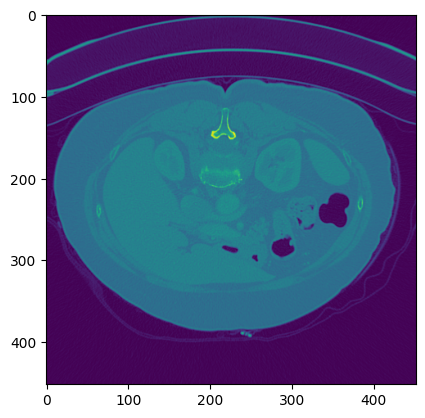

input torch.Size([1, 1, 244, 452, 452])
return z12
seg_prob_out: torch.Size([32, 257, 768])
1
b_shape torch.Size([32, 257, 768])
w_t torch.Size([1, 1, 32, 16, 16])
output_shape: [1, 768, 244, 32, 32]
torch.Size([1, 768, 244, 32, 32])
out: torch.Size([1, 768, 32, 16, 16])
p: torch.Size([768, 32, 16, 16])
return z12
seg_prob_out: torch.Size([32, 257, 768])
1
b_shape torch.Size([32, 257, 768])
w_t torch.Size([1, 1, 32, 16, 16])
torch.Size([1, 768, 244, 32, 32])
out: torch.Size([1, 768, 32, 16, 16])
p: torch.Size([768, 32, 16, 16])
return z12
seg_prob_out: torch.Size([32, 257, 768])
1
b_shape torch.Size([32, 257, 768])
w_t torch.Size([1, 1, 32, 16, 16])
torch.Size([1, 768, 244, 32, 32])
out: torch.Size([1, 768, 32, 16, 16])
p: torch.Size([768, 32, 16, 16])
return z12
seg_prob_out: torch.Size([32, 257, 768])
1
b_shape torch.Size([32, 257, 768])
w_t torch.Size([1, 1, 32, 16, 16])
torch.Size([1, 768, 244, 32, 32])
out: torch.Size([1, 768, 32, 16, 16])
p: torch.Size([768, 32, 16, 16])
return z

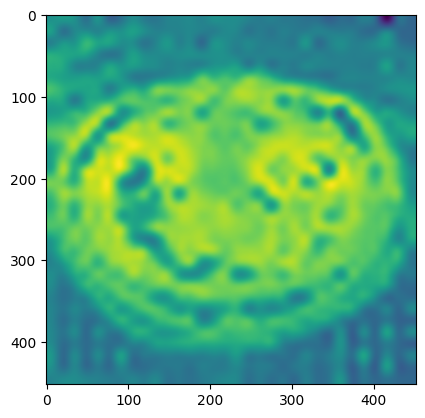

In [10]:
do_PCA(train_type = 'enc_freeze', data = 'lung', model_name = 'dino', return_point = 'z12')
